In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, BatchNormalization, Dropout


In [16]:
# Load dataset
df = pd.read_csv(r"C:\Users\ADMIN\Downloads\TASK-ML-INTERN.csv")

# Display first few rows
df.head()


,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


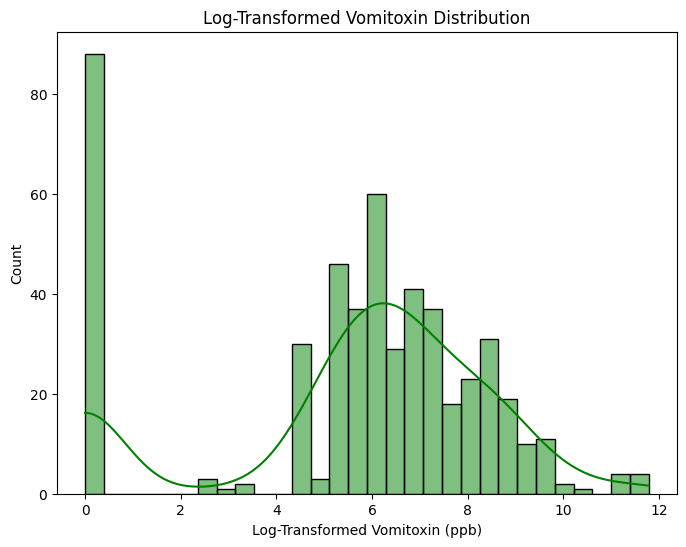

In [17]:
df["vomitoxin_ppb"] = np.log1p(df["vomitoxin_ppb"])  # log1p avoids log(0) issues

# Replot histogram after transformation
plt.figure(figsize=(8, 6))
sns.histplot(df["vomitoxin_ppb"], bins=30, kde=True, color="green")
plt.xlabel("Log-Transformed Vomitoxin (ppb)")
plt.ylabel("Count")
plt.title("Log-Transformed Vomitoxin Distribution")
plt.show()


In [18]:
# Drop 'hsi_id' as it's not needed for modeling
df = df.drop(columns=["hsi_id"])

# Separate features and target
X = df.drop(columns=["vomitoxin_ppb"]).values
y = df["vomitoxin_ppb"].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=30)  # Reduce from 448 to 30 components
X_pca = pca.fit_transform(X_scaled)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Reshape for 1D CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


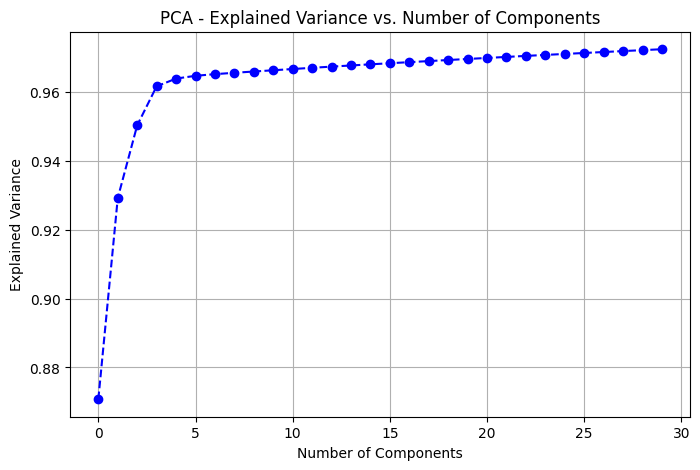

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("PCA - Explained Variance vs. Number of Components")
plt.grid()
plt.show()


In [20]:
# Build the CNN model
model = Sequential([
    Conv1D(filters=128, kernel_size=9, activation="relu", input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=64, kernel_size=5, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=32, kernel_size=3, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1)  # Regression output
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003), loss="mse", metrics=["mae"])

# Model summary
model.summary()


d:\python-coding-challenge\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 22, 128)        │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 18, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 18, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,273 (321.38 KB)

 Trainable params: 81,825 (319.63 KB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
# Train model
history = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 38.4245 - mae: 5.5632 - val_loss: 31.9425 - val_mae: 5.1353
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.6153 - mae: 3.6864 - val_loss: 18.9951 - val_mae: 4.0510
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 12.6778 - mae: 2.9354 - val_loss: 12.5539 - val_mae: 3.3002
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.3525 - mae: 2.6339 - val_loss: 9.2226 - val_mae: 2.7310
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.9487 - mae: 2.5684 - val_loss: 7.3180 - val_mae: 2.1946
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.4541 - mae: 2.4009 - val_loss: 6.7997 - val_mae: 1.8897
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6913 - mae: 2.3336 - val_loss: 6.6437 - val_mae: 1.8480
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.0239 - mae: 2.5079 - val_loss: 6.6615 - val_mae: 1.7923
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/st

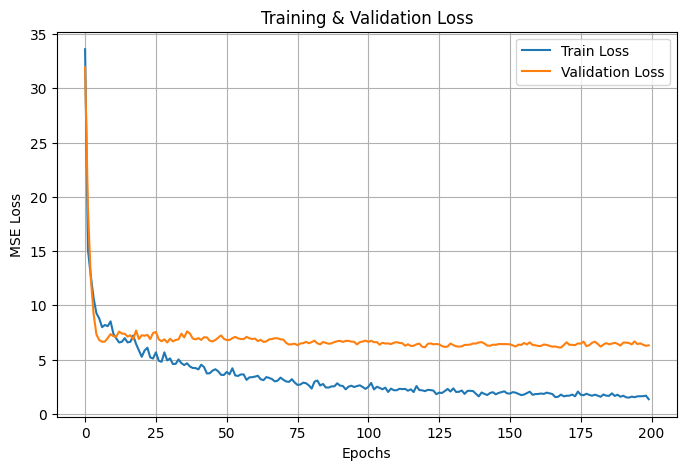

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()


In [23]:
# Predictions
y_pred = model.predict(X_test)

# Calculate RMSE and R²
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"🚀 CNN Model RMSE: {rmse:.2f}, R² Score: {r2:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
🚀 CNN Model RMSE: 2.51, R² Score: 0.2219


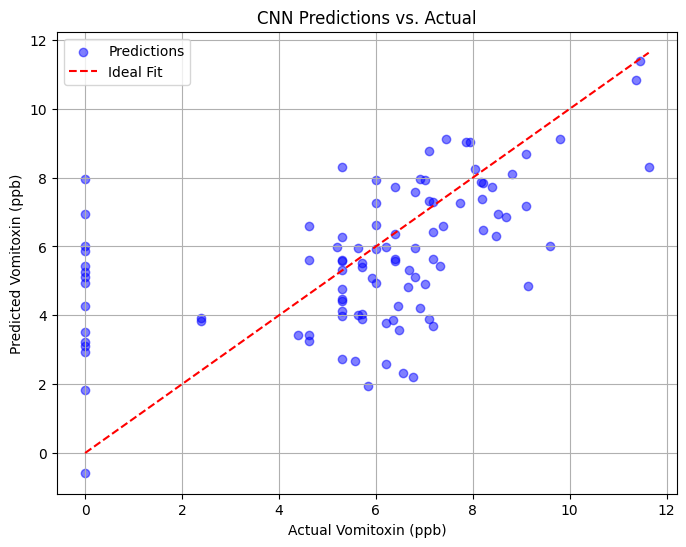

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue", label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal Fit")  # Diagonal line
plt.xlabel("Actual Vomitoxin (ppb)")
plt.ylabel("Predicted Vomitoxin (ppb)")
plt.title("CNN Predictions vs. Actual")
plt.legend()
plt.grid()
plt.show()
